In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import sys
import os
from PIL import Image
sys.path.append("..")
sys.path.append("../backbone")
from backbones import DenseNet201
from dataloader import create_dataloader
import torchvision.transforms as transforms
from transform import Transform
from data import RetinaDataset
from metric import Metric
import shap
torch.cuda.empty_cache()

# Set device to GPU if available, else use CPU
device = torch.device("cuda:0")
model = torch.load('models/dn1.pth')
model.to(device)
# device = torch.device("cpu")
print(device)
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

cuda:0
Current device: NVIDIA A100 80GB PCIe


In [2]:
data_dir = '../../../data/GT-main'
batch_size = 16
image_size = 384
num_labels = 21
num_workers = 4
thresholds = [0.5]*num_labels
idx = [26, 66, 80, 352]
phase= 'test'
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
threshold = [0.65, 0.7, 0.49, 0.43, 0.66, 0.78, 0.26, 0.21, 0.38, 0.82, 0.64, 0.9, 0.38, 0.59, 0.86, 0.31, 0.51, 0.69, 0.91, 0.23, 0.37]
class_names = ["DR","NORMAL","MH","ODC","TSLN","ARMD","DN","MYA","BRVO","ODP","CRVO","CNV","RS","ODE","LS","CSR","HTR","ASR","CRS","OTHER","RB"]
test_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='test')

384
../../../data/GT-main/./set1/test.csv


384
../../../data/GT-main/./set1/test.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


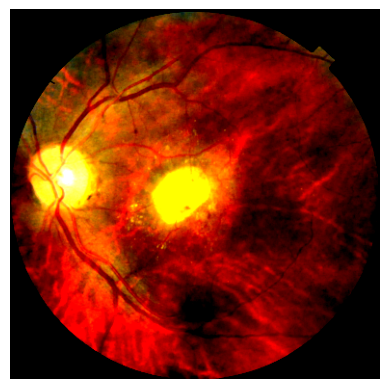

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])


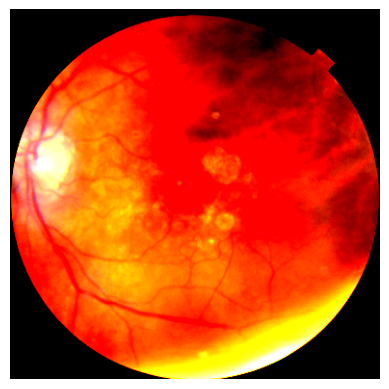

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])


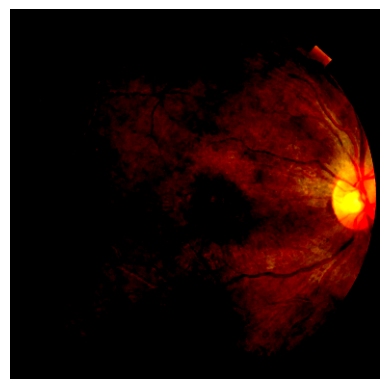

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])


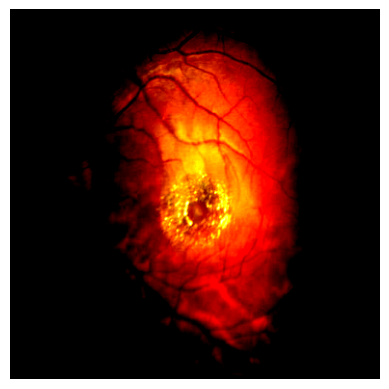

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])
[[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
torch.Size([4, 21]) torch.Size([4, 384, 384, 3])


In [3]:
transform = Transform(size=image_size, phase=phase)
label_list = []
image_list = []
dataset = RetinaDataset(data_dir=data_dir, split=phase, transform=transform)
for i in idx:
    image = dataset[i][0]
    label = dataset[i][1]
    image_list.append(image.permute(1,2,0).unsqueeze(0))
    label_list.append(label.unsqueeze(0))
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()
    print(label)
    

images = torch.cat(image_list, dim=0)
labels = torch.cat(label_list, dim=0)
true_labels = labels.detach().cpu().numpy().astype(np.int32)
print(true_labels)
print(labels.shape, images.shape)

In [4]:
def predict(x):
    tmp = torch.tensor(x).to(device)
    tmp = tmp.permute(0,3,1,2)
    return torch.sigmoid(model(tmp))

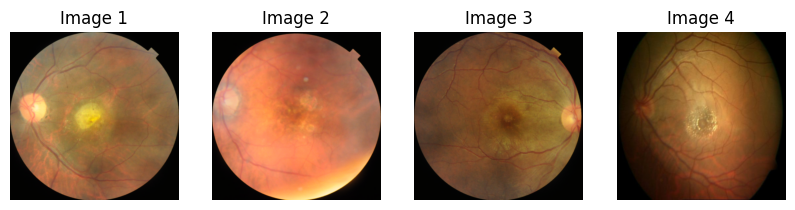

In [5]:
# Define the inverse transformation function
inv_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.permute(0, 3, 1, 2)),
    transforms.Normalize(mean=(-1 * np.array(mean) / np.array(std)).tolist(),std=(1 / np.array(std)).tolist(),),
    transforms.Lambda(lambda x: x.permute(0, 2, 3, 1)),
])

# Apply the inverse transformation to the transformed image tensor
original_images = inv_transform(images)
original_images = original_images.numpy()

# Plot the original images
plt.figure(figsize=(10, 5))
for i in range(original_images.shape[0]):
    plt.subplot(1, original_images.shape[0], i + 1)
    plt.imshow(original_images[i])
    plt.axis('off')
    plt.title(f'Image {i + 1}')
plt.show()

In [6]:
output = predict(images)
print(output)

thresholds = [0.5]*num_labels
outputs = output.detach().cpu().numpy()
outputs_thresholded = (outputs > thresholds).astype(np.int32)
print(outputs_thresholded)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[7.7174e-01, 4.5769e-03, 4.5691e-04, 5.6283e-02, 9.9001e-01, 4.1386e-01,
         2.6737e-02, 8.6943e-03, 7.7876e-05, 1.2798e-03, 4.6007e-05, 4.9782e-03,
         3.6214e-03, 7.1029e-03, 5.5134e-01, 2.6345e-02, 1.7615e-01, 3.0961e-03,
         1.3408e-03, 5.3665e-04, 1.1105e-04],
        [8.7538e-01, 1.1241e-03, 2.2849e-02, 8.0870e-02, 8.4098e-01, 1.1719e-01,
         8.2423e-04, 6.8273e-02, 4.8442e-04, 7.4404e-03, 1.9194e-04, 1.6697e-01,
         6.9763e-04, 2.3299e-02, 9.0681e-01, 3.0397e-03, 1.0728e-01, 1.0010e-02,
         1.5890e-04, 1.8096e-03, 1.3516e-04],
        [3.8956e-04, 9.4977e-03, 2.1715e-03, 2.5669e-03, 3.6942e-04, 8.3657e-02,
         3.7950e-03, 2.1592e-02, 2.9740e-05, 2.8881e-02, 1.3921e-05, 3.8102e-02,
         3.8315e-03, 5.5354e-01, 9.9483e-03, 8.4252e-01, 4.7711e-02, 1.1917e-03,
         8.1399e-04, 6.1621e-01, 2.4375e-04],
        [5.4330e-06, 3.8763e-04, 3.6390e-04, 4.2620e-05, 6.1822e-04, 3.4486e-01,
         2.1758e-04, 5.2392e-03, 1.3555e-05, 1.4725e

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix
acc_list, spec_list = [], []
labels_true = labels.detach().cpu().numpy().astype(np.int32)
for label_index in range(labels.shape[1]):
            label_true = labels_true[:, label_index]
            label_pred = outputs_thresholded[:, label_index]

            # Check if label_true and label_pred contain only one unique value
            if len(set(label_true)) == 1 and len(set(label_pred)) == 1:
                acc = accuracy_score(label_true, label_pred)
                spec = 0.0  # Set specificity to 0 when there's only one class present
            else:
                acc = accuracy_score(label_true, label_pred)
                tn, fp, _, _ = confusion_matrix(label_true, label_pred).ravel()
                spec = tn / (tn + fp) if (tn + fp) != 0 else 0.0

            acc_list.append(acc)
            spec_list.append(spec)

print(acc_list,"\n", spec_list)

[0.5, 1.0, 1.0, 1.0, 0.75, 0.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.5, 0.75, 1.0, 1.0, 1.0, 0.75, 1.0] 
 [0.5, 0.0, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.5, 0.75, 0.0, 0.0, 0.0, 0.75, 0.0]


In [8]:
print(image.shape)

torch.Size([3, 384, 384])


In [9]:
# Initialize Shapley Explainer
masker = shap.maskers.Image("blur(64,64)", shape=images[0].shape)
explainer = shap.Explainer(predict, masker, output_names=class_names)

print("Type of explainer:", type(explainer))

shap_values = explainer(images, max_evals=10000, batch_size=50, outputs=shap.Explanation.argsort.flip[:2])
torch.cuda.empty_cache()

Type of explainer: <class 'shap.explainers._partition.PartitionExplainer'>


  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 3/4 [02:06<00:31, 31.91s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 4/4 [03:08<00:00, 44.45s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [04:08, 62.09s/it]                       


In [10]:
print(shap_values.data.shape, shap_values.values.shape)

torch.Size([4, 384, 384, 3]) (4, 384, 384, 3, 2)


In [11]:
# Assuming shap_values contains your SHAP values
shap_data = inv_transform(shap_values.data).cpu().numpy()
shap_val = [val for val in np.moveaxis(shap_values.values, -1, 0)]
print(shap_data, shap_val)

[[[[7.8431452e-03 7.8431703e-03 7.8431275e-03]
   [7.8431452e-03 7.8431703e-03 7.8431275e-03]
   [7.8431452e-03 7.8431703e-03 7.8431275e-03]
   ...
   [7.8431452e-03 7.8431703e-03 7.8431275e-03]
   [7.8431452e-03 7.8431703e-03 7.8431275e-03]
   [7.8431452e-03 7.8431703e-03 7.8431275e-03]]

  [[7.8431452e-03 7.8431703e-03 7.8431275e-03]
   [7.8431452e-03 7.8431703e-03 7.8431275e-03]
   [7.8431452e-03 7.8431703e-03 7.8431275e-03]
   ...
   [7.8431452e-03 7.8431703e-03 7.8431275e-03]
   [7.8431452e-03 7.8431703e-03 7.8431275e-03]
   [7.8431452e-03 7.8431703e-03 7.8431275e-03]]

  [[7.8431452e-03 7.8431703e-03 7.8431275e-03]
   [7.8431452e-03 7.8431703e-03 7.8431275e-03]
   [7.8431452e-03 7.8431703e-03 7.8431275e-03]
   ...
   [7.8431452e-03 7.8431703e-03 7.8431275e-03]
   [7.8431452e-03 7.8431703e-03 7.8431275e-03]
   [7.8431452e-03 7.8431703e-03 7.8431275e-03]]

  ...

  [[7.8431452e-03 7.8431703e-03 7.8431275e-03]
   [7.8431452e-03 7.8431703e-03 7.8431275e-03]
   [7.8431452e-03 7.843170

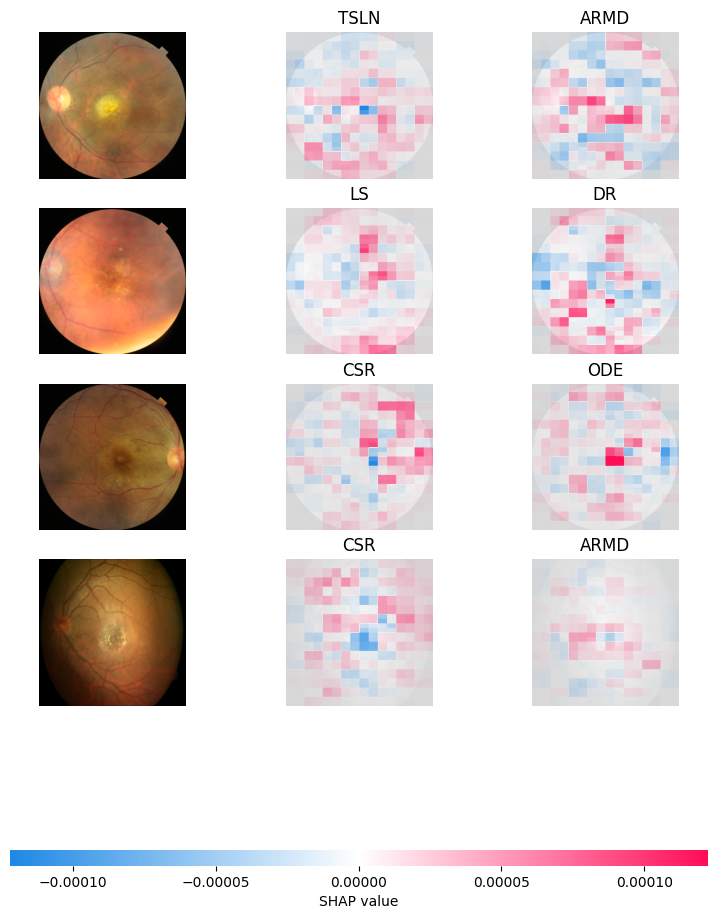

Image No. 26:
Top Predictions: 0.9900, 0.7717, 0.5513, 0.4139
Top Class IDs: [ 4  0 14  5]
Top Class Names: ['TSLN', 'DR', 'LS', 'ARMD']
Predicted Classes: ['TSLN', 'DR', 'LS']
True Classes: ['TSLN', 'ARMD']

Image No. 66:
Top Predictions: 0.9068, 0.8754, 0.8410, 0.1670
Top Class IDs: [14  0  4 11]
Top Class Names: ['LS', 'DR', 'TSLN', 'CNV']
Predicted Classes: ['LS', 'DR', 'TSLN']
True Classes: ['ARMD', 'MYA']

Image No. 80:
Top Predictions: 0.8425, 0.6162, 0.5535, 0.0837
Top Class IDs: [15 19 13  5]
Top Class Names: ['CSR', 'OTHER', 'ODE', 'ARMD']
Predicted Classes: ['CSR', 'OTHER', 'ODE']
True Classes: ['ARMD']

Image No. 352:
Top Predictions: 0.3449, 0.3245, 0.2395, 0.0484
Top Class IDs: [ 5 15 18 14]
Top Class Names: ['ARMD', 'CSR', 'CRS', 'LS']
Predicted Classes: []
True Classes: ['ARMD']



In [12]:
shap.image_plot(
    shap_values=shap_val,
    pixel_values=shap_data,
    labels=shap_values.output_names,
    # true_labels=[torch.tensor(labels)[:4][:]],
)

for i in range(len(idx)):
    sorted_output = torch.sort(output[i], descending=True)
    top_preds = np.array(sorted_output[0][:4].detach().cpu().numpy()) 
    top_indices = sorted_output[1][:4].cpu().numpy()
    formatted_preds = ', '.join([f'{pred:.4f}' for pred in top_preds])
    pred_classes = top_preds>0.5
    
    top_classes = np.where(labels[i] == 1)[0]

    print(f'Image No. {idx[i]}:\nTop Predictions: {formatted_preds}\nTop Class IDs: {top_indices}'
          f'\nTop Class Names: {[class_names[idx] for idx in top_indices]}\nPredicted Classes: {[class_names[idx] for idx in top_indices[pred_classes]]}'
          f'\nTrue Classes: {[class_names[idx] for idx in top_classes]}\n')